In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
fontsize = 20
from functools import partial, reduce
# compose = lambda *F: reduce(lambda f, g: lambda x: f(g(x)), F)
from funcy import compose
import numpy as np
from parametric_pde_find import *
from scipy.integrate import odeint
from scipy.signal import savgol_filter, periodogram
from scipy import interpolate
from scipy.integrate import trapz
from scipy.stats import wilcoxon
from numpy.fft import fft, ifft, fftfreq
from time import time
from tqdm import tqdm

from tqdm import trange
from best_subset import *
from solvel0 import solvel0
from pde_diff_new import RPCA
from tvregdiff import TVRegDiff, tvregdiff, numdiff, pysindydiff
import pynumdiff
import pynumdiff.optimize
import sys; sys.path.insert(0, "../derivative/"); import derivative
from derivative import dxdt as ddd

from sklearn.linear_model import BayesianRidge, ARDRegression, Ridge, Lasso
from sklearn.preprocessing import normalize as sk_normalize

from findiff import FinDiff
from abess.linear import LinearRegression
from UBIC import fit_blr, UBIC, decreasing_values_indices
from skscope_tools import best_subset_all_solutions, abess_all_solutions
from para_UBIC import *
from mdl_comp import RidgeMDLCOMP
# https://github.com/Pongpisit-Thanasutives/OKRidge
from okridge.solvel0 import okridge_solvel0, okridge_solvel0_full

import sys; sys.path.append('/Users/pongpisit/Documents/github/ICOMP/')
from icomp_lm import *

def coeff_error(est, ground): return 100*np.linalg.norm(est-ground, 1)/np.linalg.norm(ground, 1)

np.random.seed(1234)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Sklearn's version: 1.4.2


In [2]:
def parametric_burgers_rhs(u, t, params):
    k,a,b,c = params
    deriv = a*(1+c*np.sin(t))*u*ifft(1j*k*fft(u)) + b*ifft(-k**2*fft(u))
    return real(deriv)

# Set size of grid -> affect discovery results
n = 256
m = 256
    
# Set up grid
x = np.linspace(-8,8,n+1)[:-1];   dx = x[1]-x[0]
t = np.linspace(0,10,m);          dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, d = dx)

# Initial condition
u0 = np.exp(-(x+1)**2)

# Solve with time dependent uu_x term
params = (k, -1, 0.1, 0.25)
u = odeint(parametric_burgers_rhs, u0, t, args=(params,)).T # shape = (len(x), len(t))

u_xx_true = 0.1*np.ones(m)
uu_x_true = -1*(1+0.25*np.sin(t))

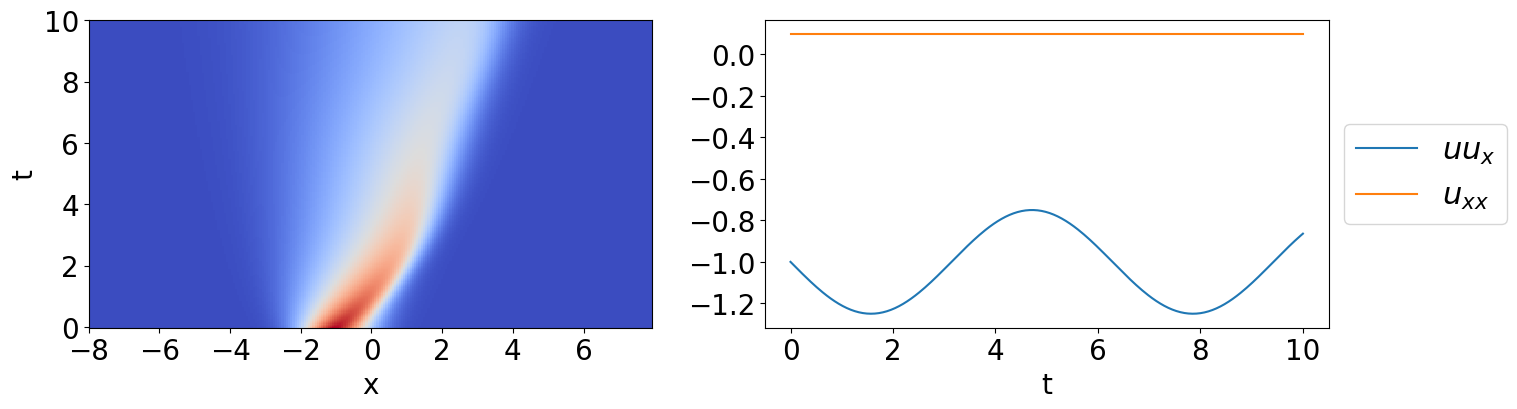

In [3]:
# Plot
fig=figure(figsize=(16,4))
X, T = np.meshgrid(x, t)

subplot(1,2,1)
pcolor(X, T, u.T, cmap=cm.coolwarm)
xlabel('x', fontsize = fontsize)
ylabel('t', fontsize = fontsize)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlim([x[0],x[-1]])

subplot(1,2,2)
plot(t, uu_x_true, label=r'$uu_{x}$')
plot(t, u_xx_true, label=r'$u_{xx}$')

xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlabel('t', fontsize = fontsize)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
# fig.tight_layout()

In [4]:
u_clean = u.copy()
u_clean_t = FinDiff(1, dt, 1, acc=4)(u_clean)
u_clean_x = FinDiff(0, dx, 1, acc=4)(u_clean)
u_clean_xx = FinDiff(0, dx, 1, acc=4)(u_clean_x)
u_clean_xxx = FinDiff(0, dx, 1, acc=4)(u_clean_xx)
u_clean_xxxx = FinDiff(0, dx, 1, acc=4)(u_clean_xxx)
noise_lv = 2
noise_lv = abs(noise_lv)
u = u + 0.01*noise_lv*std(u)*np.random.randn(n, m)

In [5]:
include_bias = False
is_denoising = True

if is_denoising and noise_lv > 0:
    window_size = 15
    poly_order = 2
    u = savgol_filter(u, window_size, poly_order, axis=1)

ttt = u.copy()
alpha = 3e-4
diff_kwargs = {"kind": "kalman", "alpha": alpha}
Ut, Theta, Ut_grouped, Theta_grouped, rhs_des = construct_group_linear_system(u, x, t, 
                                                                              diff_kwargs, 
                                                                              include_bias=include_bias, 
                                                                              dependent='temporal')
# Theta_grouped, Ut_grouped = spatial_temporal_group(Theta, Ut, (n,m), "temporal")

In [6]:
fft_percent = 90
fft_Theta_grouped = np.array([remove_f(fft(Theta_grouped[:, :, k]), fft_percent) 
                              for k in range(len(rhs_des))])
fft_Theta_grouped = np.moveaxis(fft_Theta_grouped, 0, -1)
fft_Ut_grouped = remove_f(fft(Ut_grouped[:, :, 0]), fft_percent)
fft_Ut_grouped = np.expand_dims(fft_Ut_grouped, -1)

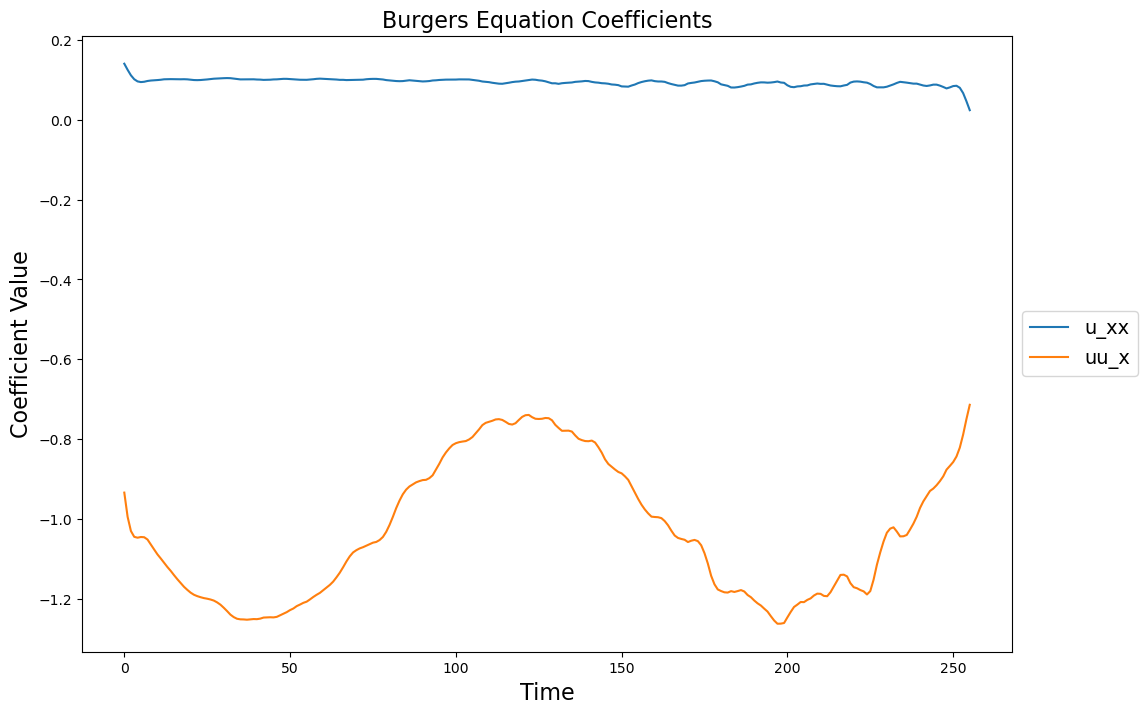

In [7]:
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped, normalize=2)
xi = Xi[np.argmin(Losses)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in np.where(np.linalg.norm(xi, axis=-1) > 1e-10)[0]:
    plot(xi[j,:], label = rhs_des[j])

title('Burgers Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
show()

In [8]:
# 0.1821324868907128
xi = xi[np.where(np.linalg.norm(xi, axis=-1))[0]]
errors = np.array([coeff_error(xi[0], u_xx_true), coeff_error(xi[1], uu_x_true)])
print(errors)
errors.mean(), errors.std()

[6.99894796 1.69902758]


(4.348987768945098, 2.6499601871300618)

In [9]:
max_complexity = 10
candidates = [[] for _ in range(max_complexity)]
for i in trange(len(Theta_grouped)):
    candidates_i = sorted(set(solvel0(Theta_grouped[i], Ut_grouped[i], max_complexity=max_complexity, 
                                      miosr=True, refine=True, verbose=False)), key=len)
    for i in range(max_complexity):
        candidates[i].append(candidates_i[i])
candidates   

  0%|                                                                                                            | 0/256 [00:00<?, ?it/s]

Set parameter Username


2024-05-04 14:16:50,602 [INFO] Set parameter Username


Academic license - for non-commercial use only - expires 2024-06-04


2024-05-04 14:16:50,605 [INFO] Academic license - for non-commercial use only - expires 2024-06-04
100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [05:01<00:00,  1.18s/it]


[[(7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),


2 1 2


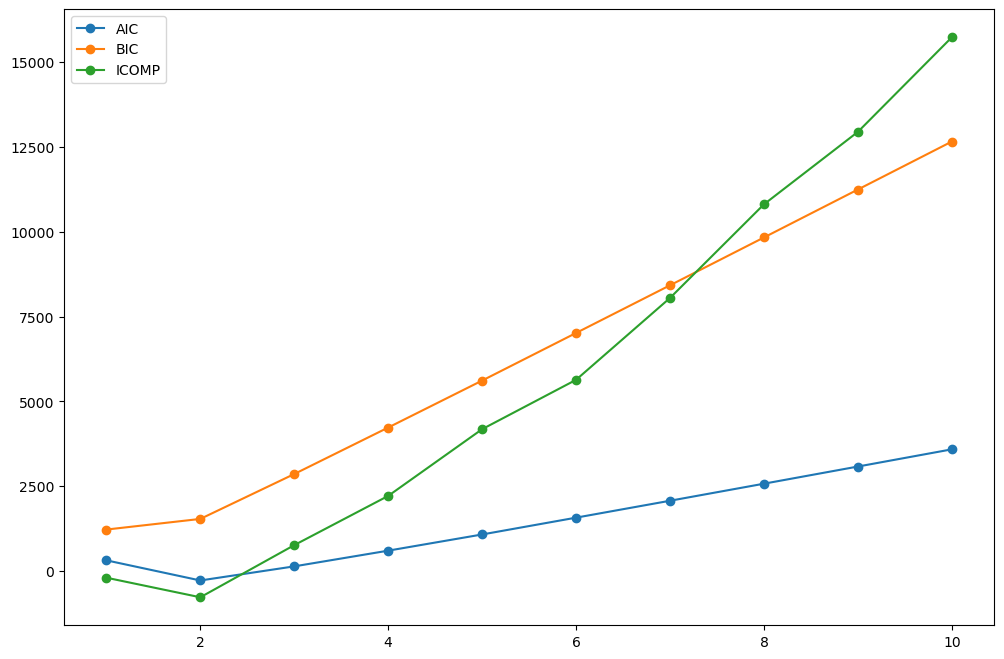

In [10]:
# from scipy import linalg as splinalg
# from scipy.sparse import csc_array, csc_matrix
# from scipy.sparse import linalg as splin

# for indices in sorted(candidates, key=len):
#     theta_b = csc_matrix(splinalg.block_diag(*[Theta_grouped[j][:, indices] for j in range(len(Theta_grouped))]), dtype=float)
#     ut_b = Ut_grouped.reshape(-1, 1)
#     xi_b = splin.lsqr(theta_b, ut_b)[0].reshape(-1, 1)
#     rss = np.sum((ut_b-theta_b@xi_b)**2)
#     print(len(indices), rss2bic(rss, np.count_nonzero(xi_b), len(ut_b)))
#     break

time_integrator = lambda _: _
time_integrator = partial(trapz, axis=1)
time_integrator = compose(time_integrator, 
                          lambda _ : periodogram(_, return_onesided=False, axis=1)[1])
epsilon = 0
ic_scores = {}
ICOMPs = []; a_n = 1
AICs = []
BICs = []
for candidate in candidates:
    CMs = []
    k = 0
    est_xi = np.zeros((Theta_grouped[0].shape[-1], len(Ut_grouped)))
    for j in range(len(Theta_grouped)):
        est_xi[candidate[j], j:j+1] = np.linalg.lstsq(Theta_grouped[j][:, candidate[j]], Ut_grouped[j], rcond=None)[0]
        _, CM, _ = llf_complexity(Theta_grouped[j][:, candidate[j]], Ut_grouped[j], a_n=None)
        CMs.append(CM[1])
        k += len(candidate[j])

    Ut_grouped_est = estimate_Ut_grouped_est(Theta_grouped, est_xi)
    rss = rss_group(Ut_grouped_est, Ut_grouped, time_integrator)
    # N = np.prod(Ut_grouped.shape)
    N = np.prod(time_integrator(Ut_grouped).shape)
    
    # aic = PDE_FIND_Loss(Theta_grouped, Ut_grouped, est_xi)
    # bic = BIC_Loss(Theta_grouped, Ut_grouped, est_xi)
    aic = N*np.log(2*np.pi*rss/N+epsilon) + 2*k
    bic = N*np.log(2*np.pi*rss/N+epsilon) + np.log(N)*k
    icomp = N*np.log(2*np.pi*rss/N+epsilon) + 2*a_n*np.sum(CMs)
    AICs.append(aic)
    BICs.append(bic)
    ICOMPs.append(icomp)

print(np.argmin(AICs)+1, np.argmin(BICs)+1, np.argmin(ICOMPs)+1)
plt.plot([_+1 for _ in range(max_complexity)], AICs, '-o', label='AIC')
plt.plot([_+1 for _ in range(max_complexity)], BICs, '-o', label='BIC')
plt.plot([_+1 for _ in range(max_complexity)], ICOMPs, '-o', label='ICOMP')
plt.legend()
plt.show()

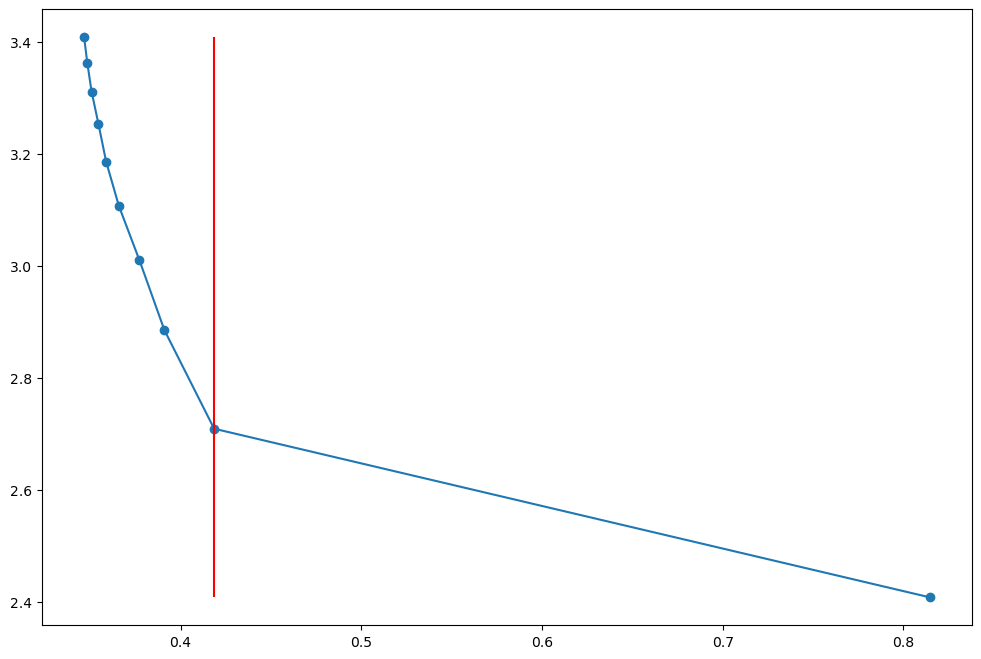

In [11]:
log_errors = []
log_coms = []
for candidate in candidates:
    com = 0
    rss = 0
    for j in range(len(Ut_grouped)):
        est_xi = SkLinearRegression(fit_intercept=False).fit(Theta_grouped[j][:, candidate[j]], Ut_grouped[j]).coef_.reshape(-1, 1)
        difference = Ut_grouped[j] - Theta_grouped[j][:, candidate[j]].dot(est_xi)
        rss += np.sum(difference**2)
        com += len(candidate[j])
    log_error = np.log10(np.sqrt(rss))
    log_com = np.log10(com)
    log_errors.append(log_error)
    log_coms.append(log_com)
plt.plot(log_errors, log_coms, '-o')
plt.vlines(find_corner(log_errors, log_coms), ymin=min(log_coms), ymax=max(log_coms), color='red')
plt.show()